In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import plotly.express as px
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

ROOT = Path("/Users/rhishabhpatil/Desktop/Portfolio/Churn_Dashboard")
OUT = ROOT / "outputs"
(OUT / "data").mkdir(parents=True, exist_ok=True)
(OUT / "models").mkdir(parents=True, exist_ok=True)
(OUT / "figures").mkdir(parents=True, exist_ok=True)

In [3]:
df = pd.read_csv(ROOT / "data" / "WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

df['Churn'] = (df['Churn'] == "Yes").astype(int)

X = pd.get_dummies(df.drop(columns=['Churn','customerID']), drop_first=True)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [7]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, proba)
auc


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8365399050582127

In [9]:
joblib.dump(model, OUT / "models" / "churn_model.joblib")

['/Users/rhishabhpatil/Desktop/Portfolio/Churn_Dashboard/outputs/models/churn_model.joblib']

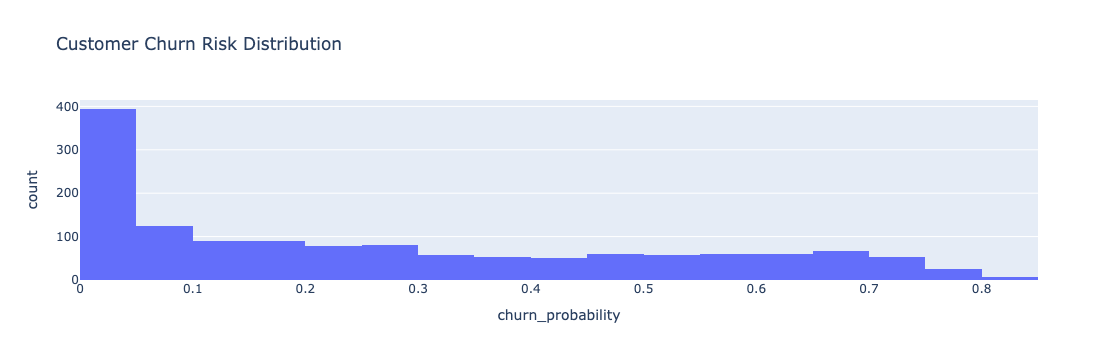

In [11]:
risk = pd.DataFrame({"churn_probability": proba})
fig = px.histogram(risk, x="churn_probability", nbins=40, title="Customer Churn Risk Distribution")
fig.write_html(OUT / "figures" / "churn_risk.html")
fig


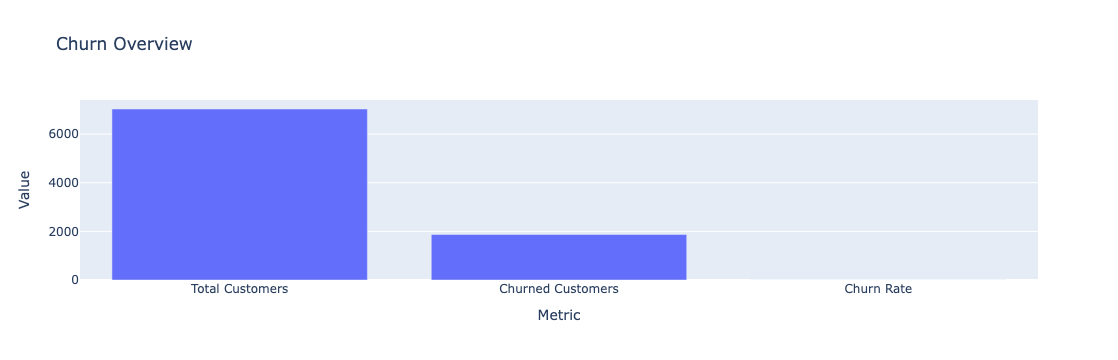

In [13]:
kpi = pd.DataFrame({
    "Metric":["Total Customers","Churned Customers","Churn Rate"],
    "Value":[len(df), df["Churn"].sum(), df["Churn"].mean()]
})

fig2 = px.bar(kpi, x="Metric", y="Value", title="Churn Overview")
fig2.write_html(OUT / "figures" / "churn_kpis.html")
fig2


In [15]:
df.to_csv(OUT / "data" / "processed_churn.csv", index=False)


In [17]:
total_customers = len(df)
churned_customers = df["Churn"].sum()
churn_rate = churned_customers / total_customers

# Simulate monthly revenue per customer (for business storytelling)
np.random.seed(42)
df["monthly_revenue"] = np.random.gamma(100, 2, size=len(df))
revenue_at_risk = df.loc[df["Churn"]==1, "monthly_revenue"].sum()

kpis = {
    "Total Customers": total_customers,
    "Churned Customers": int(churned_customers),
    "Churn Rate": round(churn_rate*100, 2),
    "Revenue at Risk ($)": round(revenue_at_risk, 2)
}

kpis

{'Total Customers': 7032,
 'Churned Customers': 1869,
 'Churn Rate': 26.58,
 'Revenue at Risk ($)': 375618.74}

In [19]:
pd.DataFrame.from_dict(kpis, orient="index", columns=["Value"]).to_csv(
    OUT / "data" / "kpis.csv"
)